In [1]:
# import our python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots
from astropy.table import Table, Column
from scipy import optimize
import math
import json
from astropy.io import ascii

In [51]:
asciiLC = 'supernova1b_template.dat'
filterNames = ['u', 'g', 'r', 'i', 'z']
colors = {'u':'purple','g':'g','r':'r','i':'blue','z':'m'}
#location_of_peak = np.arange(59580, 63232, 30)
location_of_peak = [61000]
height_of_peak = [18]
#height_of_peak = np.arange(17,21,1)

In [3]:
# Set the database and query
runName = 'kraken_1052'
opsdb = db.OpsimDatabase(runName + '_sqlite.db')

# Set the output directory
outDir = 'Observations Dictionary'
resultsDb = db.ResultsDb(outDir)

In [56]:
# The pass metric just passes data straight through.
#choose database and restrictions (such as list of ra and dec)
metric = metrics.PassMetric(cols=['expMJD','filter','fiveSigmaDepth'])
#slicer = slicers.UserPointsSlicer(np.random.uniform(0,360,1000), np.random.uniform(-60,-30,1000))
#slicer = slicers.UserPointsSlicer([349.4,0.00,53.0,34.4,150.4],[-63.3,-45.5,-27.4,-5.1,2.8])
slicer = slicers.UserPointsSlicer(0.,-45.5)
#no restrictions currently
sql = ''
bundle = metricBundles.MetricBundle(metric,slicer,sql)
bg =  metricBundles.MetricBundleGroup({0:bundle}, opsdb,
                                        outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with no constraint.
Found 3226890 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
def createdict_for_mjd_filter_depth(bundle):
    
    """This function returns a list of tables of exposure day, filter, 
    and five sigma depth for each ra and dec chosen"""
    number_of_coord = len(bundle.metricValues)
    listofDict = []
    for coord in range(len(bundle.metricValues)):
        if isinstance(bundle.metricValues[coord],np.ma.MaskedArray):
            number_of_coord -= 1
        else:
            t = Table(bundle.metricValues[coord])
            t.rename_column('expMJD', 'day')
            t = t[t['filter'] != 'y']
            t.sort('day')
            listofDict.append(t)
    return listofDict, number_of_coord

In [6]:
def read_lightcurve(asciifile, f):
    "Reads asciifile columns corresponding to each f - 3 columns (day, magnitude, error)"
    skip = 0
    if f == 'u':
        columns = (0,1,2)
        skip = 40
    elif f == 'g':
        columns = (3,4,5)
    elif f == 'r':
        columns = (6,7,8)
    elif f == 'i':
        columns = (9,10,11)
    elif f == 'z':
        columns = (12,13,14)
    else:
        pass
    lc = np.genfromtxt(asciifile, dtype=[('day', np.float), ('mag', np.float), ('error', np.float)],
                       skip_header = 1, skip_footer = skip, usecols = columns)
    return {f:lc}

In [7]:
def add_data_to_lc_table(asciiLC, template):
    '''This function returns a table with phase, magnitude, and filter for a light curve read
    in from an ascii file'''
    for f in filterNames:  
        curvedata = read_lightcurve(asciiLC, f)
        bdict = {key: curvedata[f][key] for key in ['day', 'mag', 'error']}
        t = Table(bdict)
        t['filter'] = f
        for row in range(len(t)):
            t['mag'][row] = -2.5*math.log10(t['mag'][row])
            template.add_row(t[row])
    template.sort('day')
    return template

In [8]:
def normalize_template(template):
    "Shifts template so that peak in g filter occurs at (0,0)"
    peaktable = peak_brightness(template)
    peakmag = peaktable['g'][1]
    template['mag'] -= peakmag
    return template

In [9]:
def peak_brightness(template):
    
    """This function returns a table of peak magnitude and the day it occurs 
    for each filter from the read in lightcurve"""
    
    peak_brightness = {}
    for f in filterNames:
        fMatch = np.where(template['filter'] == f)
        maxmag = np.amin(template['mag'][fMatch])
        location = np.argmin(template['mag'][fMatch])
        maxday = template['day'][fMatch][location]
        peak_brightness[f] = [maxday, maxmag]
    
    peak = Table(peak_brightness)
    peak[' '] = ['day', 'mag']
    orderedPeak = peak[' ','u','g','r','i','z']
    return orderedPeak

In [10]:
def adjust_peak(template, peakday, peakmag):
    adjusted_template = template.copy()
    """This function finds the necessary adjustment needed to make the peak 
    of the red filter occur at the right place and adjusts all filters by that same ammount"""
    
    adjusted_template['day'] += peakday
    adjusted_template['mag'] += peakmag
    
    return adjusted_template

In [11]:
def adjust_opsim_table(opsim, adjusted_template):
    """Cuts off parts of opsim that we will not use - those outside the range of the adjusted_template"""
    new_opsim = opsim.copy()
    new_opsim = new_opsim[new_opsim['day']< adjusted_template['day'].max()]
    new_opsim = new_opsim[new_opsim['day']> adjusted_template['day'].min()]
    return new_opsim

In [12]:
def interpolate_lightcurve(adjusted_template, new_opsim):
    
    #for each filter interpolate the read in light curve to the days of the opsim in all filters
    
    lc = {}
    for f in filterNames:
        fMatch = np.where(adjusted_template['filter'] == f)
        lc[f] = np.interp(new_opsim['day'], adjusted_template['day'][fMatch], adjusted_template['mag'][fMatch])
    lightcurve = Table(lc)
    lightcurve['day'] = new_opsim['day']
    lightcurve = lightcurve['day', 'u', 'g', 'r', 'i', 'z']
    return lightcurve

In [13]:
def resample_lightcurve(lightcurve, new_opsim):
    
    """Add to the opsim table a magnitude column where the magnitude is taken 
    from the index of the interpolated light curve where both the filter and day matched the opsim"""
    
    new_opsim['magnitude'] = 0.
    for row in range(len(new_opsim)):
        filterName = new_opsim['filter'][row]
        new_opsim['magnitude'][row] = lightcurve[filterName][row]
    return new_opsim

In [14]:
def calculate_error(new_opsim):
    
    #Calculate the error of the magnitude at each point from the magnitude and fiveSigmaDepth stored in opsim
    
    snr = 5.*10.**(-0.4*(new_opsim['magnitude'] - new_opsim['fiveSigmaDepth']))
    lc_err = 2.5/(np.log(10)*snr)
    new_opsim['error'] = lc_err
    
    return new_opsim

In [15]:
def magnitude_distribution(new_opsim):
    """Let magnitude of the resampled points be on the normal distribution calculated using the exact magnitude
        and the error"""
    new_opsim['magnitude'] = np.random.normal(new_opsim['magnitude'], new_opsim['error'])
    return new_opsim

In [16]:
def func_per_filter(f):
    #Function used for template fitting
    def func(time, peak_mag, peak_time):
        new_template = template.copy()
        new_template['mag'] += peak_mag
        new_template['day'] += peak_time
        fMatch = np.where(new_template['filter'] == f)
        model = np.interp(time, new_template['day'][fMatch], new_template['mag'][fMatch],left=99,right=99)
        return model
    return func

In [17]:
def fit_curve(opsim_fmatch2, f):
    #Use curve_fit to find a peak magnitude and peak day using template fitting with above function
    initial_parameters = [opsim_fmatch2['magnitude'].min(), 
                          opsim_fmatch2['day'][opsim_fmatch2['magnitude'].argmin()]]
    popt, pcov = optimize.curve_fit(func_per_filter(f), opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch2['error'])
    return popt

In [18]:
def func2(x, a, b, c, x0):
    #Function used for polynomial fitting
    return a*(x-x0)**2 + b*(x-x0) + c

In [19]:
def fit_curve2(opsim_fmatch, template_fmatch2):
    #Use curve_fit to find a, b, c, x0 from the above function
    opsim_fmatch = opsim_fmatch[opsim_fmatch['day'] <= template_fmatch2['day'].max()]
    peak_day = opsim_fmatch['day'][opsim_fmatch['magnitude'].argmin()]
    peak_mag = opsim_fmatch['magnitude'].min()
    x_min = opsim_fmatch['day'].min()
    y_min = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmin()]
    x_max = opsim_fmatch['day'].max()
    y_max = opsim_fmatch['magnitude'][opsim_fmatch['day'].argmax()]
    if x_min != peak_day:
        a = (y_min - peak_mag) / ((x_min - peak_day)**2)
    else:
        a = (y_max - peak_mag) / ((x_max - peak_day)**2)
    initial_parameters = [a, 0, peak_mag, peak_day]
    popt, pcov = optimize.curve_fit(func2, opsim_fmatch['day'], opsim_fmatch['magnitude'], 
                                    p0 = initial_parameters, sigma = opsim_fmatch['error'])
    return popt

In [20]:
def create_curve(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt):
    #plot points, template, and template fitting
    plt.plot(xdata, func_per_filter(f)(xdata, *popt), 'black' , label='fit')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [49]:
def create_curve2(f, ra, dec, peakday, peakmag, opsim_fmatch2, template_fmatch2, xdata, popt2):
    #plot points, template, and polynomial fitting
    plt.plot(xdata, func2(xdata, *popt2), 'teal', label = 'poly')
    plt.errorbar(opsim_fmatch2['day'], opsim_fmatch2['magnitude'], 
                   yerr = opsim_fmatch2['error'], fmt = 'o', color=colors[f], label=f)
    plt.plot(template_fmatch2['day'], template_fmatch2['mag'], 
                     color=colors[f], label=f)
    plt.xlabel('day')
    plt.ylabel('magnitude')
    plt.ylim(22,15)
    plt.legend(numpoints = 1)
    plt.title('Lightcurve at ra = %r and dec = %r, peakday = %r and peakmag = %r'
              %(round(ra,3), round(dec,3), peakday, peakmag))
    plt.show()

In [22]:
def resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt, popt2):
    """Calculate difference in peak between template and template fitting, return in form of table with
        ra, dec, and peak difference"""
    peak_magnitude_difference_shift = template_fmatch2['mag'].min() - func_per_filter(f)(xdata, *popt).min()
    peak_magnitude_difference_poly = template_fmatch2['mag'].min() - func2(xdata, *popt2).min()

    return [ra, dec, f, peak_magnitude_difference_shift, peak_magnitude_difference_poly]

In [23]:
def resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2):
    """Calculate difference in peak between template and polynomial fitting, return in form of table with
        ra, dec, and peak difference"""
    actual_peak_day = template_fmatch2['day'][template_fmatch2['mag'].argmin()]
    
    fitted_peak_day_shift = func_per_filter(f)(xdata, *popt).argmin() + xdata.min()
    peak_day_difference_shift = actual_peak_day - fitted_peak_day_shift
    
    fitted_peak_day_poly = func2(xdata, *popt2).argmin() + xdata.min()
    peak_day_difference_poly = actual_peak_day - fitted_peak_day_poly
    
    return [ra, dec, f, peak_day_difference_shift, peak_day_difference_poly]

In [24]:
def create_peak_difference_table(peak):

    peak_difference = Table(names=('ra', 'dec', 'filter', peak + ' 1', peak + ' 2'), 
                                dtype=('float', 'float', 'string', 'float', 'float'))
    return peak_difference

In [38]:
survey, number_of_coord = createdict_for_mjd_filter_depth(bundle)

In [26]:
template = Table(names=('day', 'mag', 'error', 'filter'), 
                       dtype=('float', 'float', 'float', 'string'))
template = add_data_to_lc_table(asciiLC, template)
peaktable = peak_brightness(template)
template = normalize_template(template)

peak1 = 'peak magnitude difference'
peak2 = 'peak day difference'

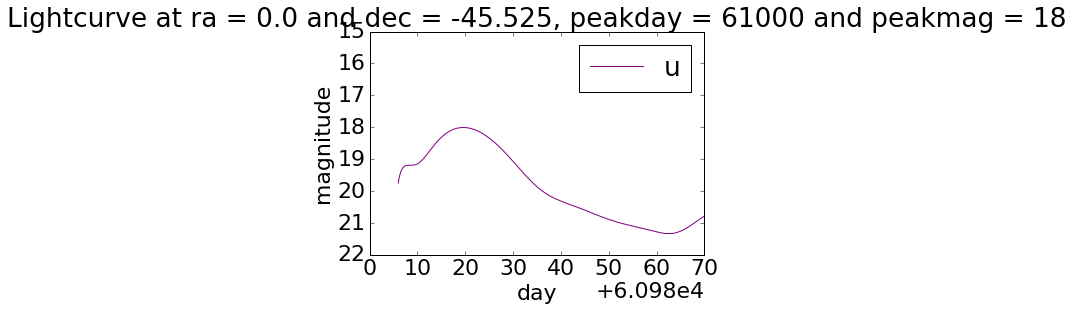

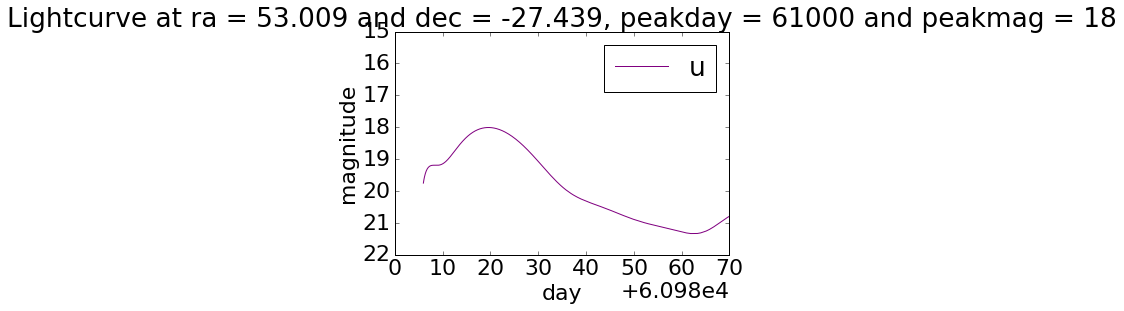

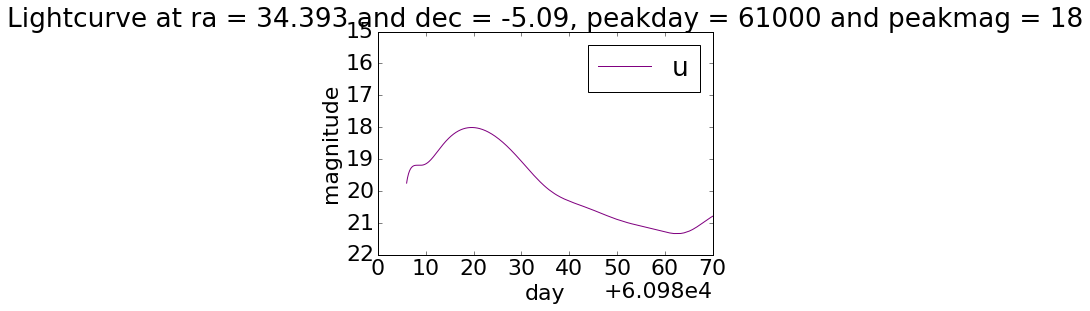

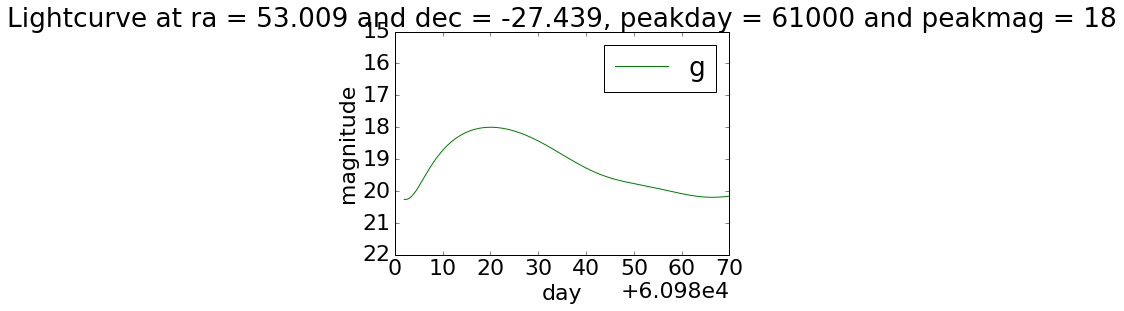

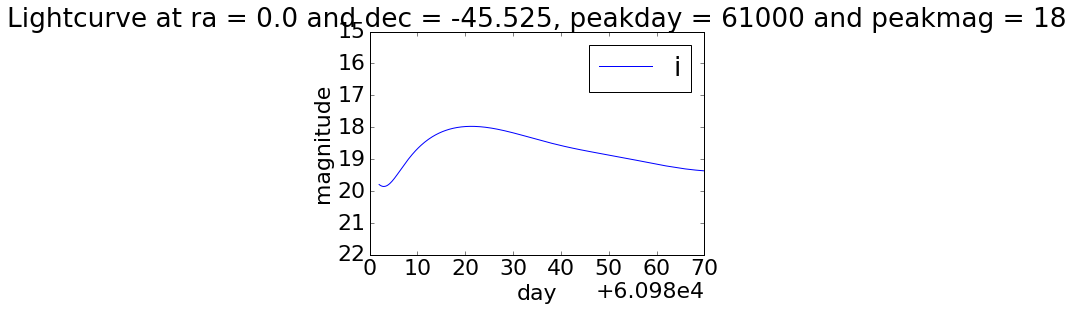

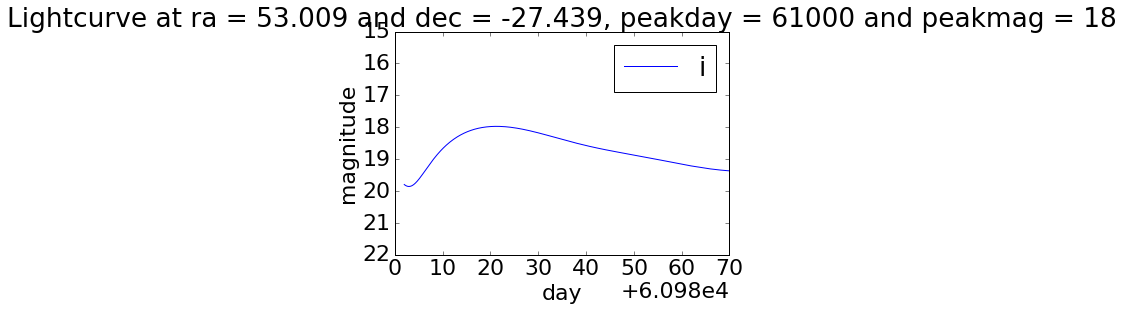

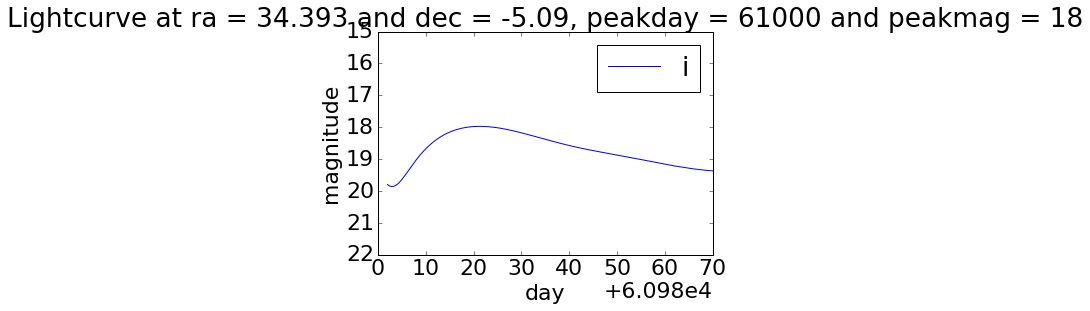

"                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 5:\n                            bad_fit_template += 1\n                            good += 1\n                            enough += 1\n                            enough_by_filter += 1\n                        else:\n                            peak_mag_difference_template.add_row(peak_mag_list)\n                            peak_day_difference_template.add_row(peak_day_list)\n                            strong_template += 1\n                            good += 1\n                            enough += 1\n                            enough_by_filter += 1\n                        if abs(peak_mag_list[4]) > 0.5 or abs(peak_day_list[4]) > 5:\n                            bad_fit_polynomial += 1\n                        else:\n                            peak_mag_difference_poly.add_row(peak_mag_list)\n                            peak_day_difference_poly.add_row(peak_day_list)\n                            stron

In [55]:
peak_mag_difference_template = create_peak_difference_table(peak1)
peak_day_difference_template = create_peak_difference_table(peak2)
peak_mag_difference_poly = create_peak_difference_table(peak1)
peak_day_difference_poly = create_peak_difference_table(peak2)
strong_template = 0
strong_polynomial = 0
bad_fit_template = 0
bad_fit_polynomial = 0
unobserved = 0
weak = 0.
enough = 0.
percent_by_filter = Table(names=('filter','percent'),dtype=('object','float'))
for f in filterNames:
    percent_by_coord = Table(names=('ra', 'dec', 'percent'), dtype=('float','float','float'))
    enough_by_filter = 0.
    not_enough_by_filter = 0.
    for coord in range(number_of_coord):
        good = 0.
        bad = 0.
        opsim = survey[coord]
        ra = np.degrees(opsim['fieldRA'][0])
        dec = np.degrees(opsim['fieldDec'][0])
        for peakday in location_of_peak:
            for peakmag in height_of_peak:
                adjusted_template = adjust_peak(template, peakday, peakmag)
                new_opsim = adjust_opsim_table(opsim, adjusted_template)
                if len(new_opsim) == 0:
                    unobserved += 1
                else:
                    lightcurve = interpolate_lightcurve(adjusted_template, new_opsim)
                    new_opsim = resample_lightcurve(lightcurve, new_opsim)
                    new_opsim = calculate_error(new_opsim)
                    new_opsim = magnitude_distribution(new_opsim)
                    final_opsim = new_opsim.copy()
                    final_opsim = final_opsim[final_opsim['day'] <= (30 + adjusted_template['day'].min())]
                    fMatch = np.where(final_opsim['filter'] == f)
                    opsim_fmatch = final_opsim[fMatch]
                    opsim_fmatch['day'] = np.round(opsim_fmatch['day'])
                    if len(np.unique(opsim_fmatch['day'])) >= 4:
                        fMatch2 = np.where(new_opsim['filter'] == f)
                        opsim_fmatch2 = new_opsim[fMatch2]
                        fMatch3 = np.where(template['filter'] == f)
                        template_fmatch = template[fMatch3]
                        fMatch4 = np.where(adjusted_template['filter'] == f)
                        template_fmatch2 = adjusted_template[fMatch4]
                        
                        xdata = np.arange(template_fmatch2['day'].min(), template_fmatch2['day'].max(), 1)
                        popt = fit_curve(opsim_fmatch2, f)
                        popt2 = fit_curve2(opsim_fmatch, template_fmatch2)
                        peak_mag_list = resampled_peak_magnitude(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        peak_day_list = resampled_peak_day(ra, dec, f, template_fmatch2, xdata, popt, popt2)
                        if abs(peak_mag_list[3]) > 0.5 or abs(peak_day_list[3]) > 5:
                            bad_fit_template += 1
                            good += 1
                            enough += 1
                            enough_by_filter += 1
                        else:
                            peak_mag_difference_template.add_row(peak_mag_list)
                            peak_day_difference_template.add_row(peak_day_list)
                            strong_template += 1
                            good += 1
                            enough += 1
                            enough_by_filter += 1
                        if abs(peak_mag_list[4]) > 0.5 or abs(peak_day_list[4]) > 5:
                            bad_fit_polynomial += 1
                        else:
                            peak_mag_difference_poly.add_row(peak_mag_list)
                            peak_day_difference_poly.add_row(peak_day_list)
                            strong_polynomial += 1
                    else:
                        weak += 1
                        bad += 1
                        not_enough_by_filter += 1
                        
        percent = (good/(good+bad))*100
        percent_by_coord.add_row([ra,dec,percent])
    import healpy as hp
    ra = np.radians(percent_by_coord['ra'])
    dec = np.radians(90 - percent_by_coord['dec'])
    nside = 16
    pix = hp.pixelfunc.ang2pix(nside, dec, ra)
    healpix_map = np.zeros(hp.nside2npix(nside), dtype=np.double)
    healpix_map[pix] = percent_by_coord['percent']
    m = np.arange(hp.nside2npix(nside))
    hp.mollview(healpix_map, coord='E', title='Map for ' + f, unit='mK', min=0 ,max=100, xsize=2000)
    percent_by_filter.add_row([f,(enough_by_filter/(enough_by_filter + not_enough_by_filter))*100])

In [40]:
print percent_by_filter

filter    percent   
------ -------------
     u 42.5790754258
     g 36.9829683698
     r 39.6593673966
     i  43.795620438
     z 41.8491484185


In [41]:
statistics = Table(names=('filter','percent observed','mean mag','std mag','mean day','std day'), 
                   dtype=('object','float','float','float','float','float')) 

In [42]:
mean_mag_difference_poly = np.mean(peak_mag_difference_poly['peak magnitude difference 2'])
std_mag_difference_poly = np.std(peak_mag_difference_poly['peak magnitude difference 2'])

mean_day_difference_poly = np.mean(peak_day_difference_poly['peak day difference 2'])
std_day_difference_poly = np.std(peak_day_difference_poly['peak day difference 2'])

percent_observed = (enough/(enough+weak))*100

statistics.add_row(['general',round(percent_observed,3),round(mean_mag_difference_poly,3),
                    round(std_mag_difference_poly,3),round(mean_day_difference_poly,3),round(std_day_difference_poly,3)])

In [43]:
for f in filterNames:
    fMatch1 = peak_mag_difference_poly['filter'] == f
    mean_mag_difference_poly = np.mean(peak_mag_difference_poly[fMatch1]['peak magnitude difference 2'])
    std_mag_difference_poly = np.std(peak_mag_difference_poly[fMatch1]['peak magnitude difference 2'])
    
    fMatch2 = peak_day_difference_poly['filter'] == f
    mean_day_difference_poly = np.mean(peak_day_difference_poly[fMatch2]['peak day difference 2'])
    std_day_difference_poly = np.std(peak_day_difference_poly[fMatch2]['peak day difference 2'])
    
    fMatch3 = percent_by_filter['filter'] == f
    percent_observed = percent_by_filter[fMatch3]['percent']
    statistics.add_row([f,round(percent_observed,3),round(mean_mag_difference_poly,3),round(std_mag_difference_poly,3),
                        round(mean_day_difference_poly,3),round(std_day_difference_poly,3)])

In [44]:
file2 = open("histogram_stats.txt", "w+")
ascii.write(statistics, file2, format='fixed_width')
file2.flush()

In [45]:
file1 = open("general_results_per_filter.txt", "w+")
file1.write("unobserved = %d \n" %(unobserved))
file1.write("weak = %d \n" %(weak))
file1.write("strong template = %d \n" %(strong_template))
file1.write("bad fit template = %d \n" %(bad_fit_template))
file1.write("strong polynomial = %d \n" %(strong_polynomial))
file1.write("bad_fit_polynomial = %d \n" %(bad_fit_polynomial))
file1.flush()

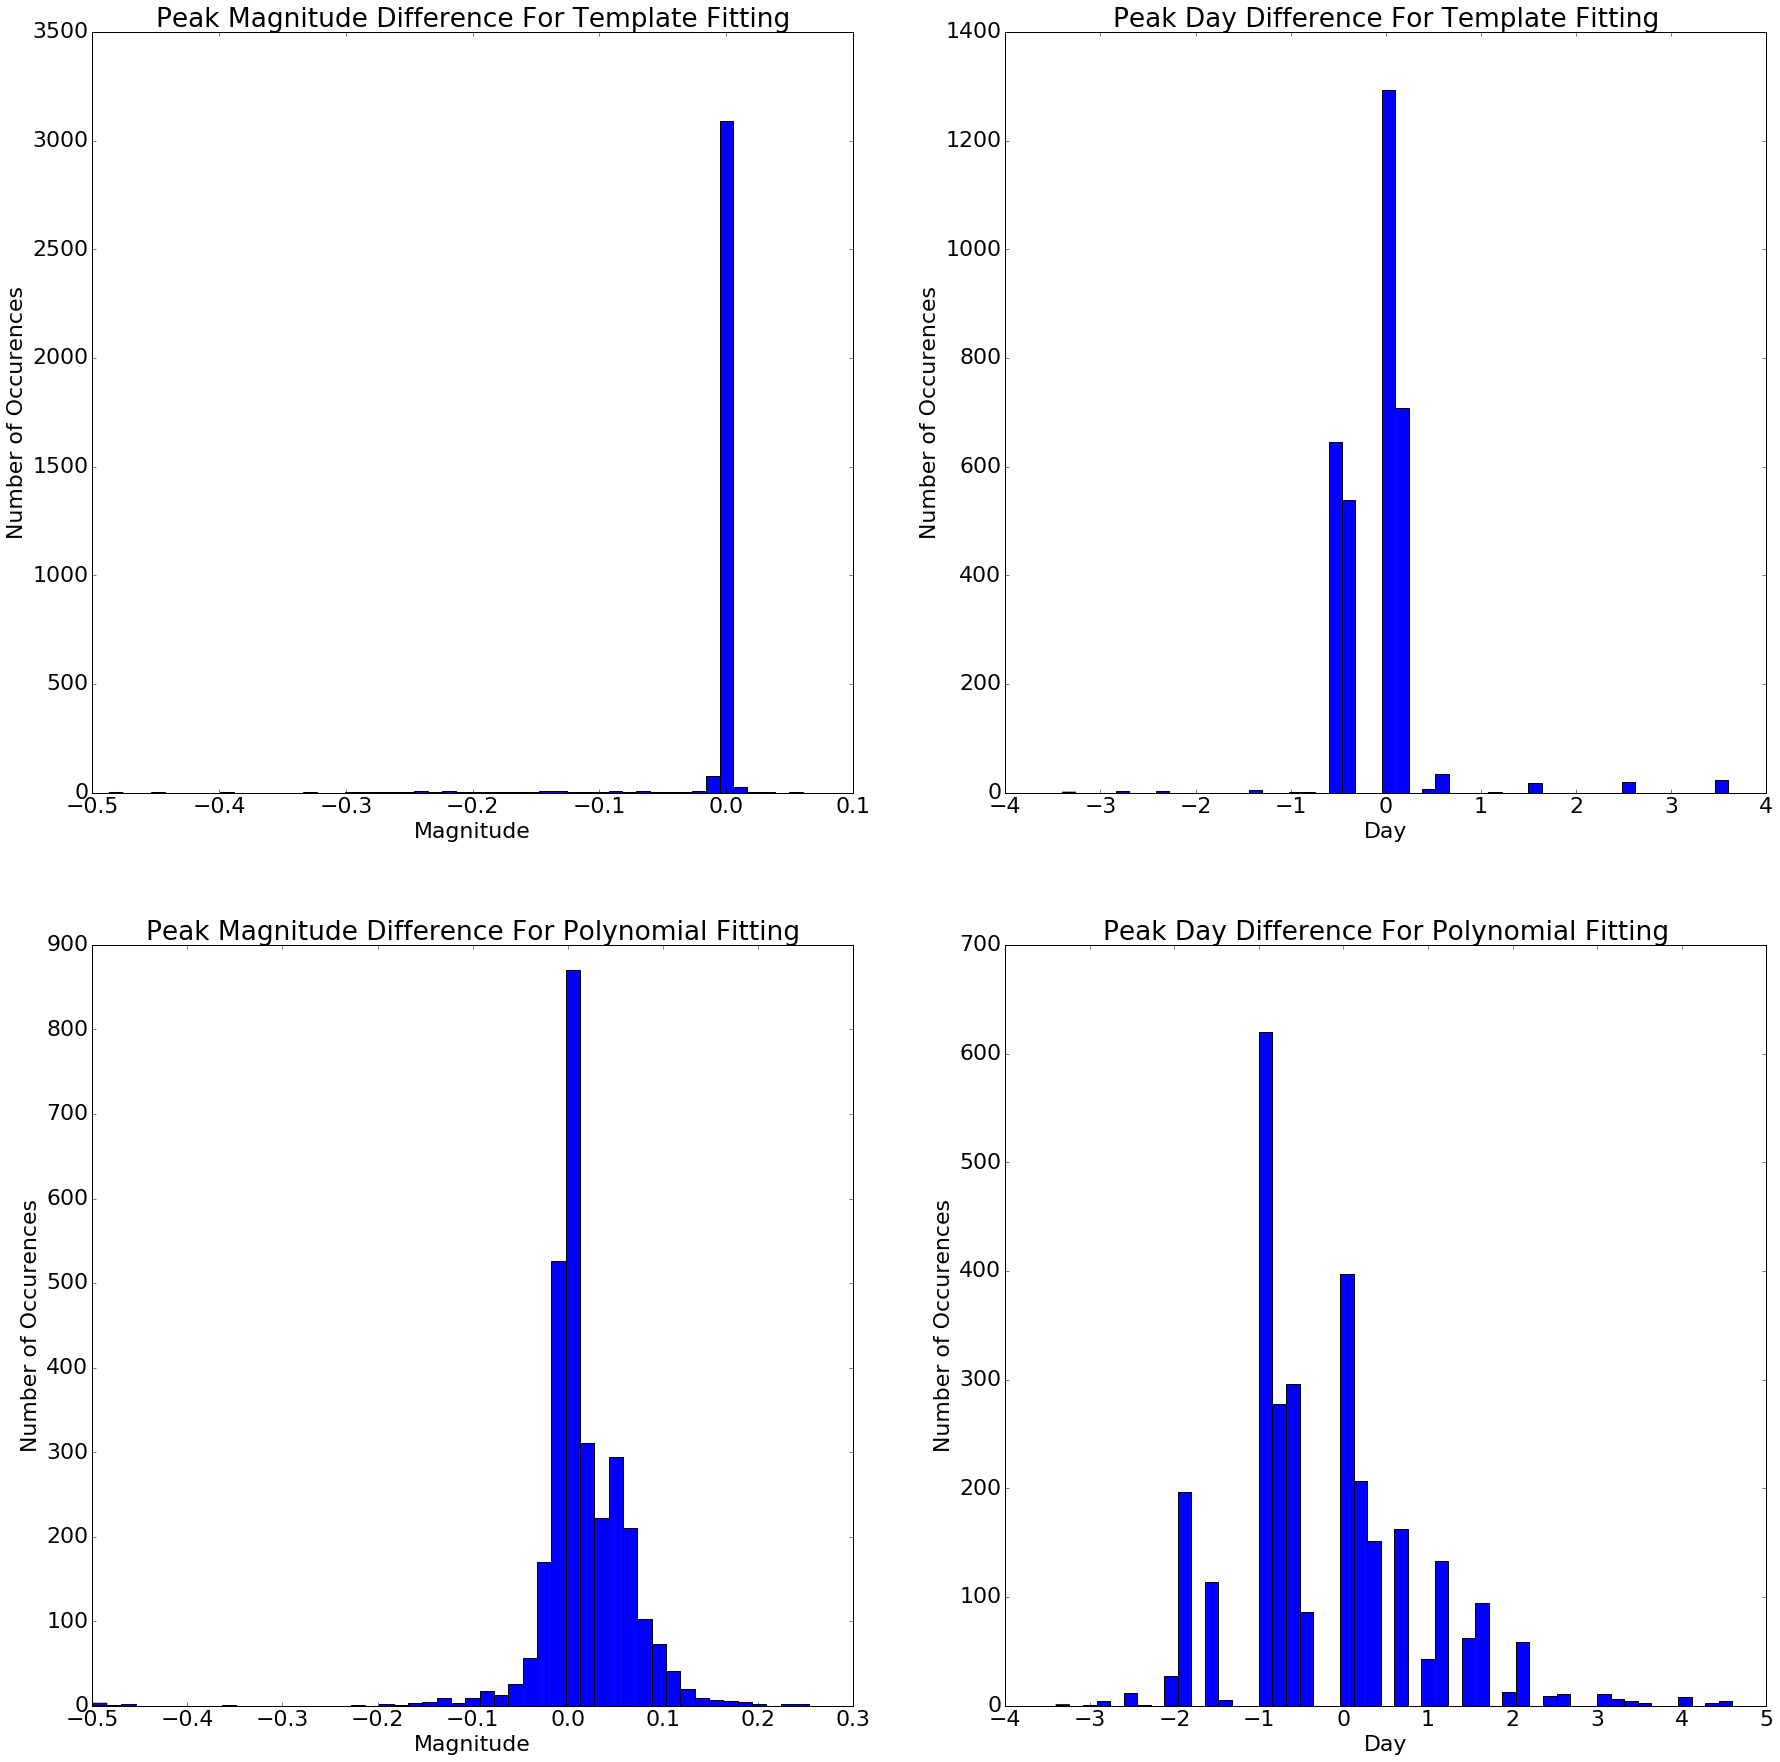

In [46]:
plt.rcParams.update({'font.size': 22})
f, axarr = plt.subplots(2,2,figsize=(30,30))
axarr[0,0].hist(peak_mag_difference_template['peak magnitude difference 1'], bins = 50)
axarr[0,0].set_title('Peak Magnitude Difference For Template Fitting')
axarr[0,0].set_xlabel('Magnitude')
axarr[0,0].set_ylabel("Number of Occurences")
axarr[0,1].hist(peak_day_difference_template['peak day difference 1'], bins = 50)
axarr[0,1].set_title('Peak Day Difference For Template Fitting')
axarr[0,1].set_xlabel('Day')
axarr[0,1].set_ylabel("Number of Occurences")
axarr[1,0].hist(peak_mag_difference_poly['peak magnitude difference 2'], bins = 50)
axarr[1,0].set_title('Peak Magnitude Difference For Polynomial Fitting')
axarr[1,0].set_xlabel('Magnitude')
axarr[1,0].set_ylabel("Number of Occurences")
axarr[1,1].hist(peak_day_difference_poly['peak day difference 2'], bins = 50)
axarr[1,1].set_title('Peak Day Difference For Polynomial Fitting')
axarr[1,1].set_xlabel('Day')
axarr[1,1].set_ylabel("Number of Occurences")
#f.subplots_adjust(hspace=1.0, wspace = 1.0)
f.savefig("results_histograms.pdf")

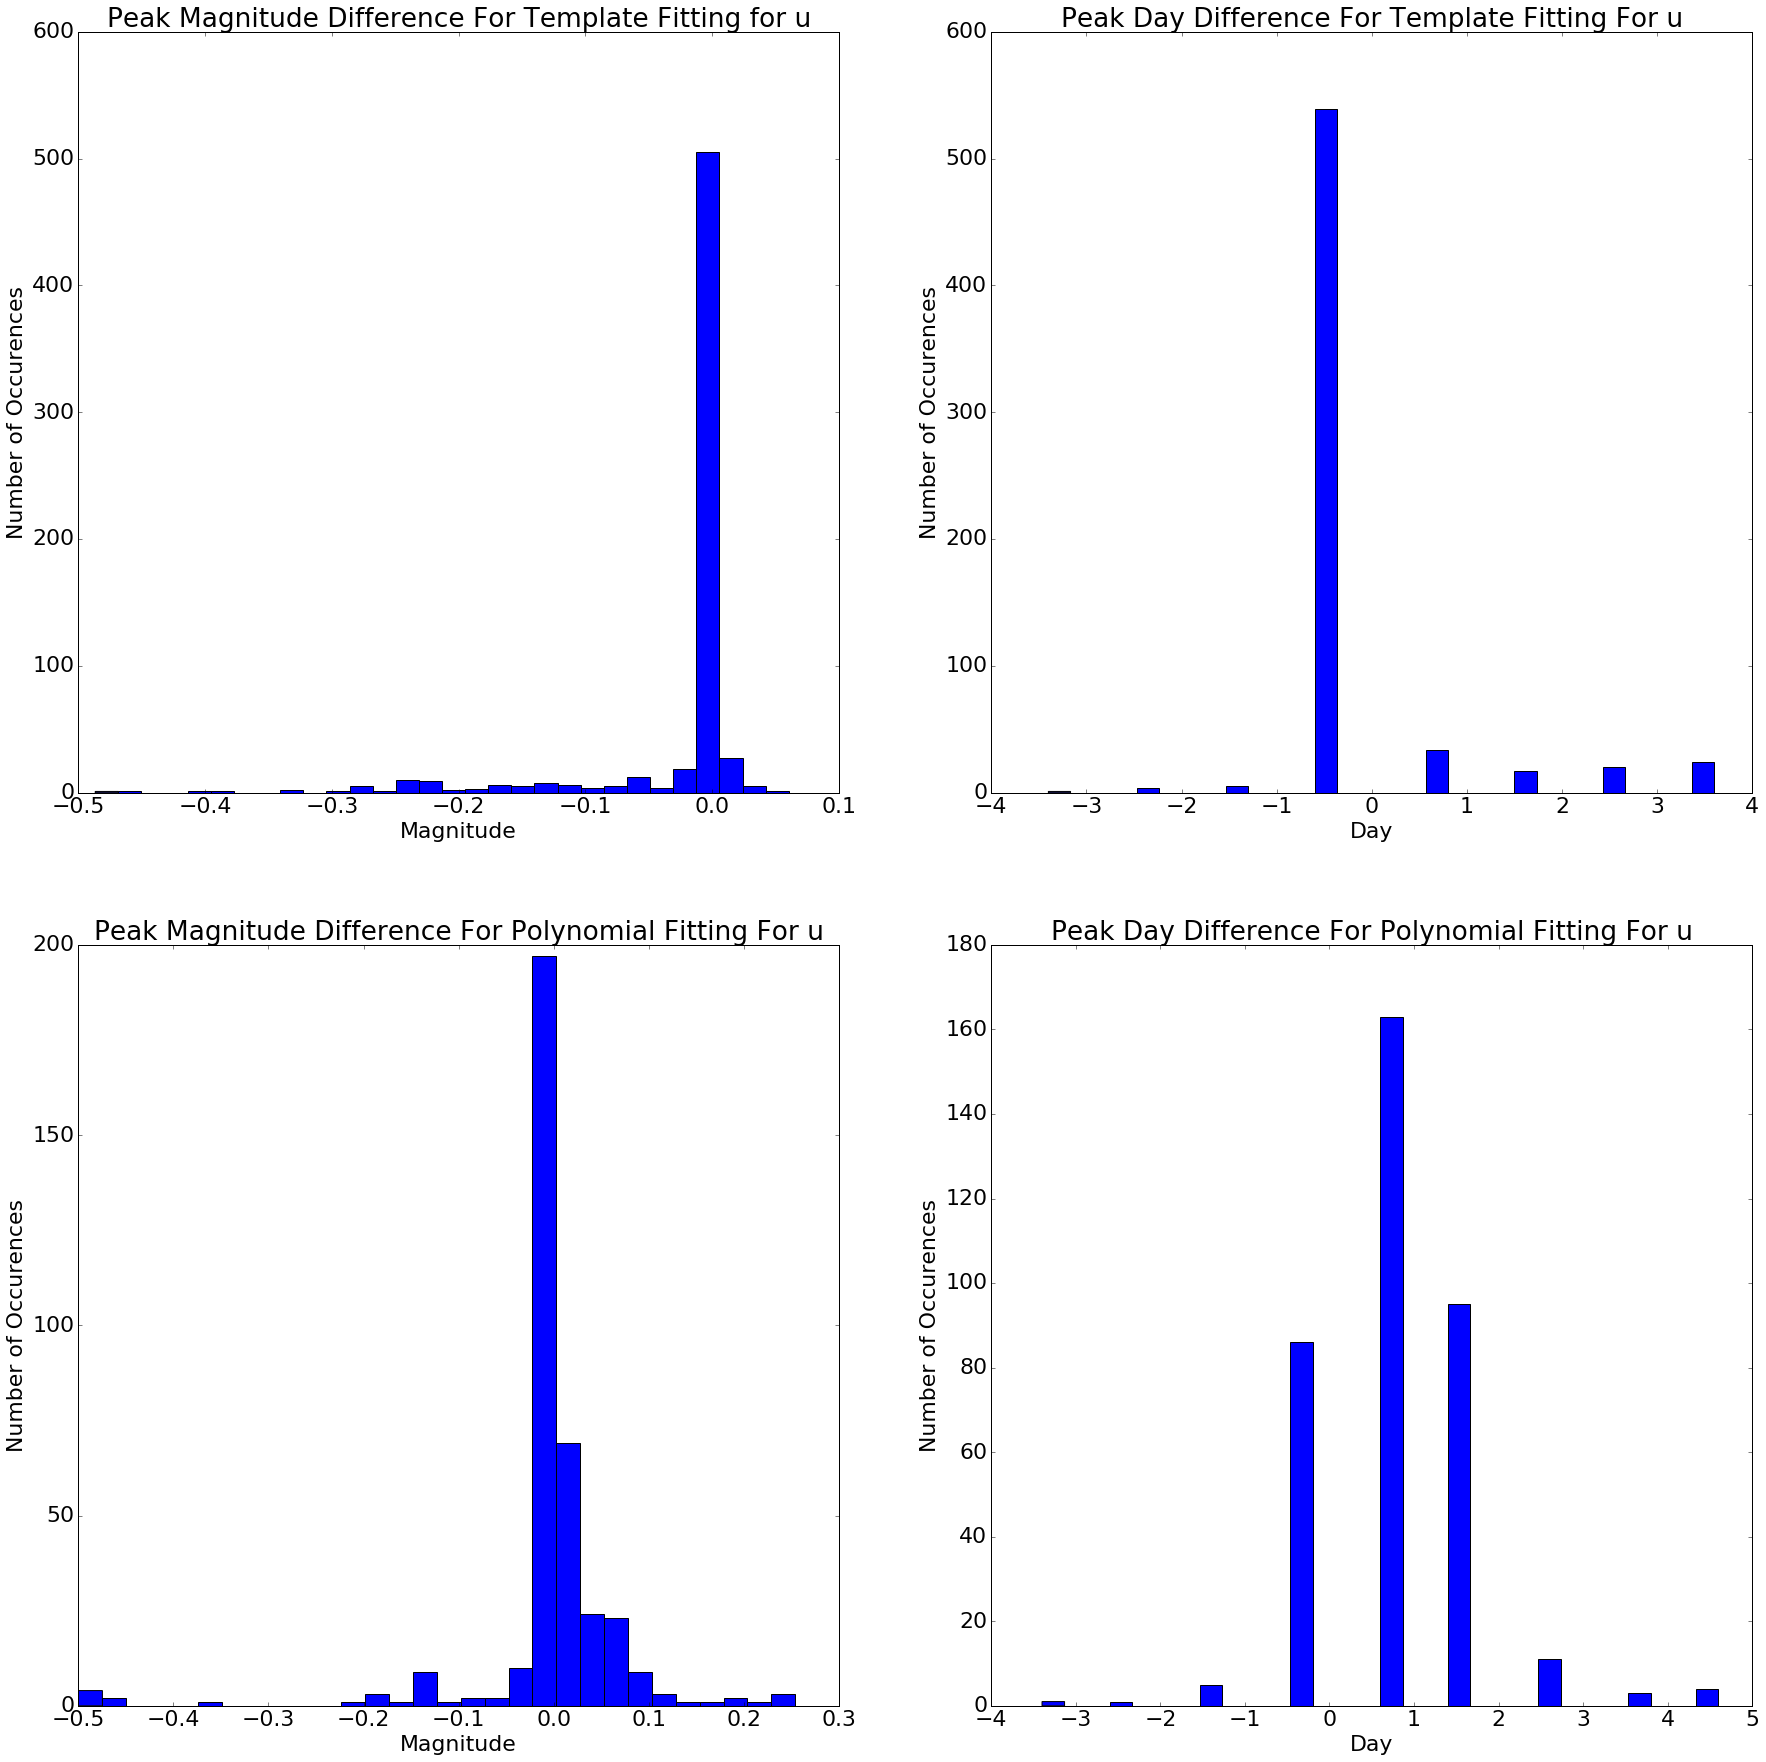

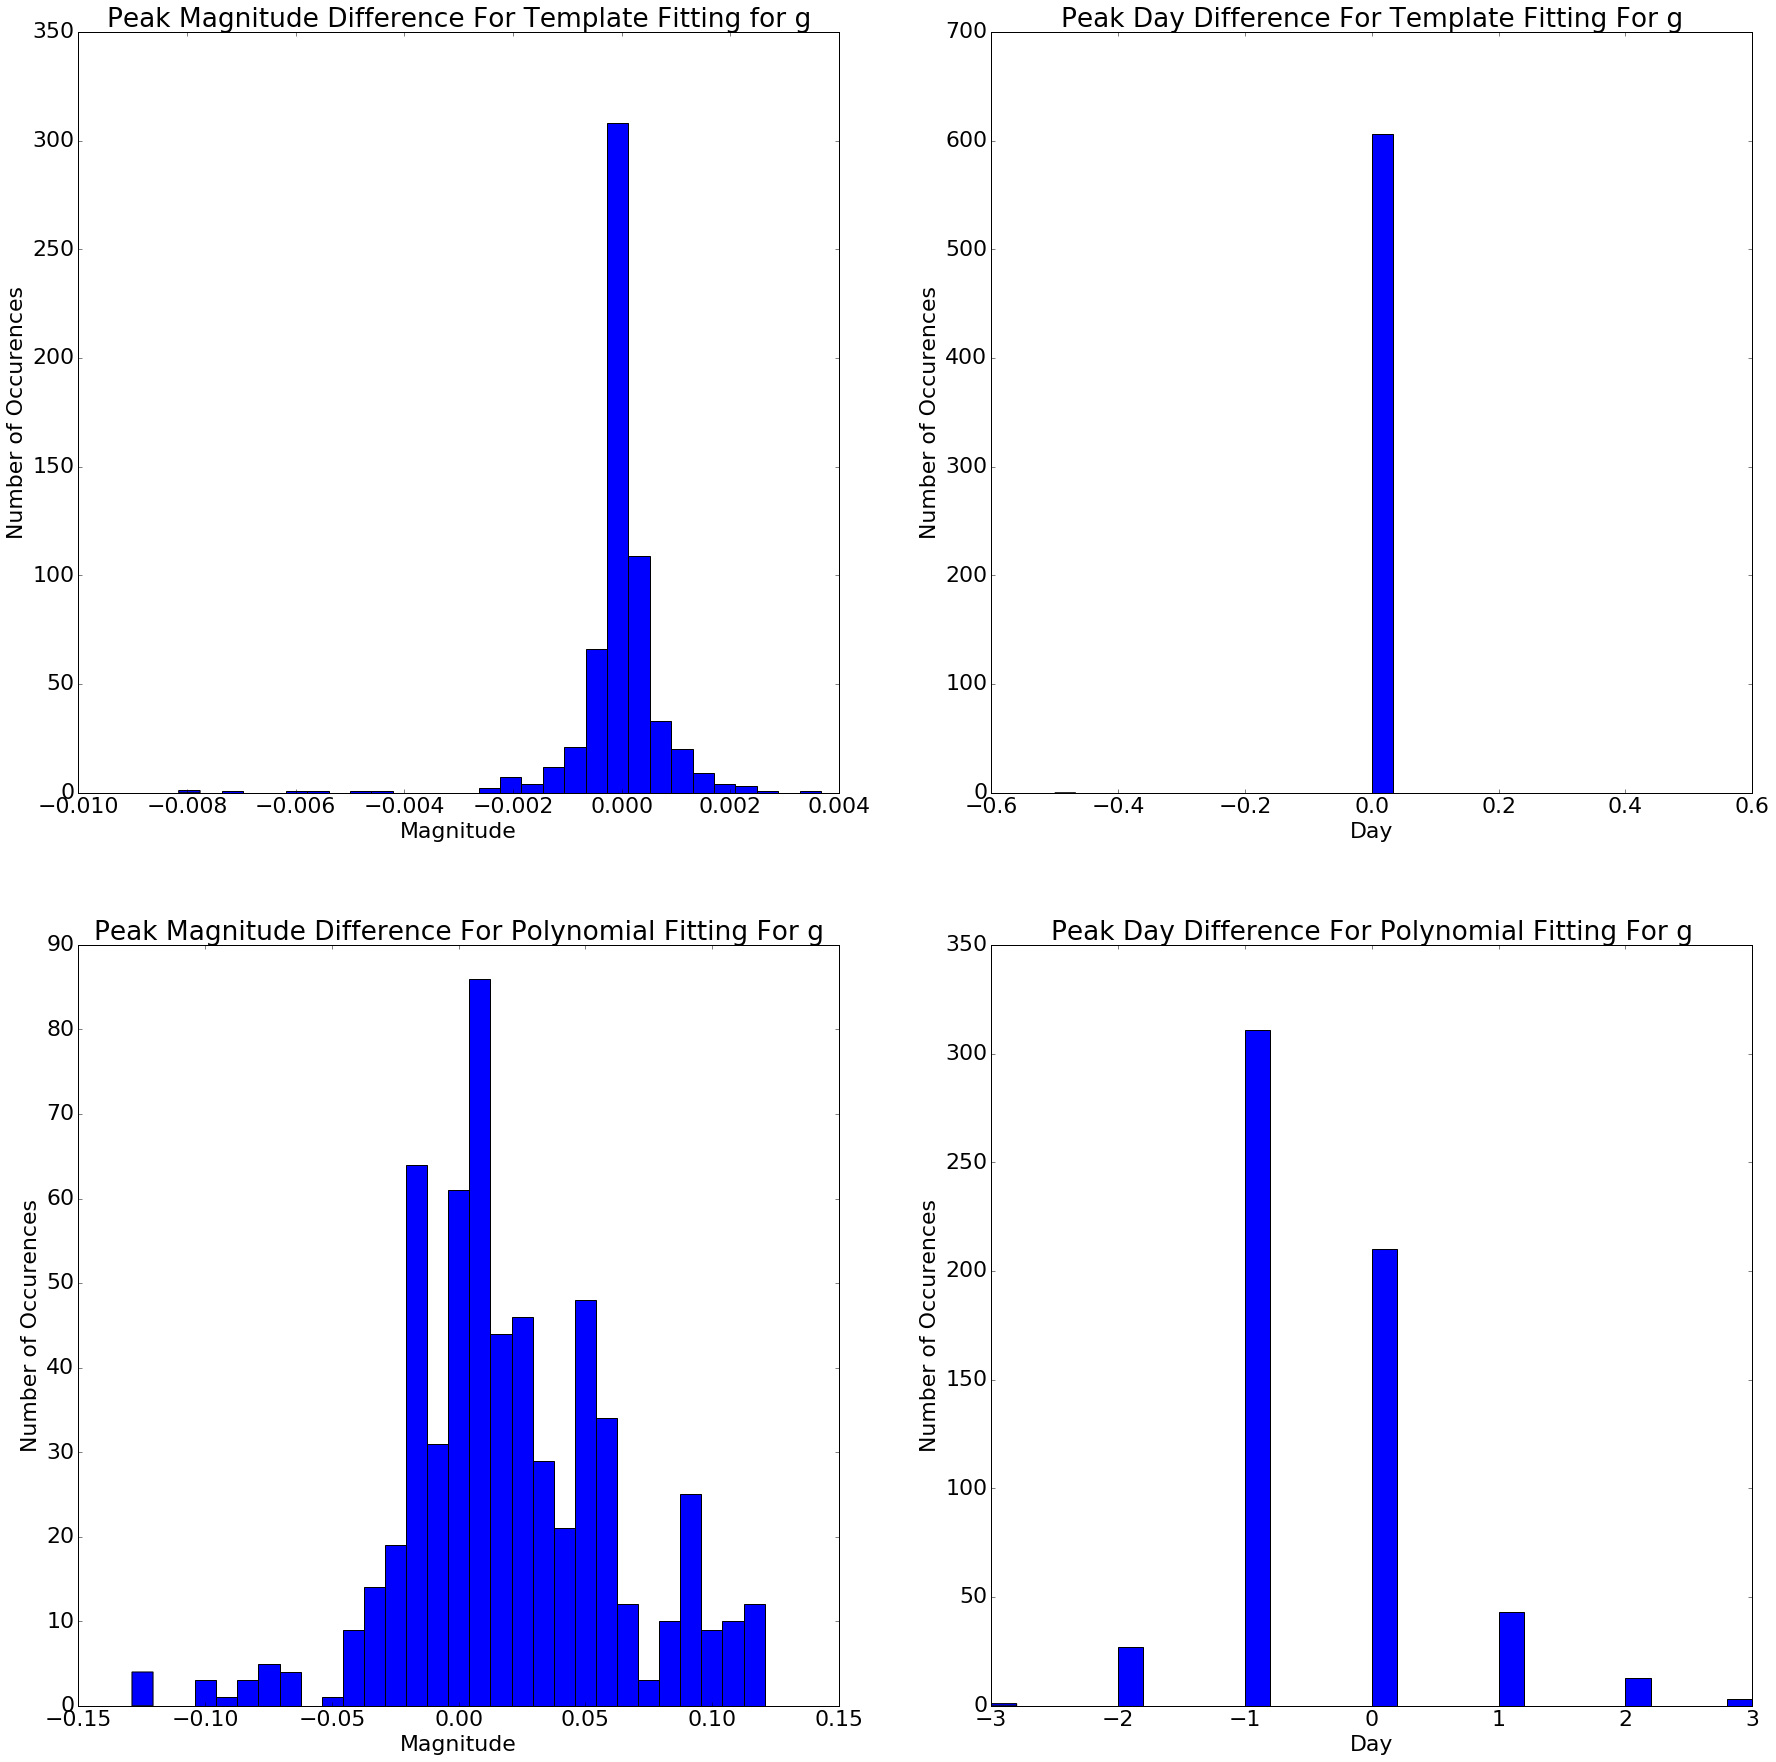

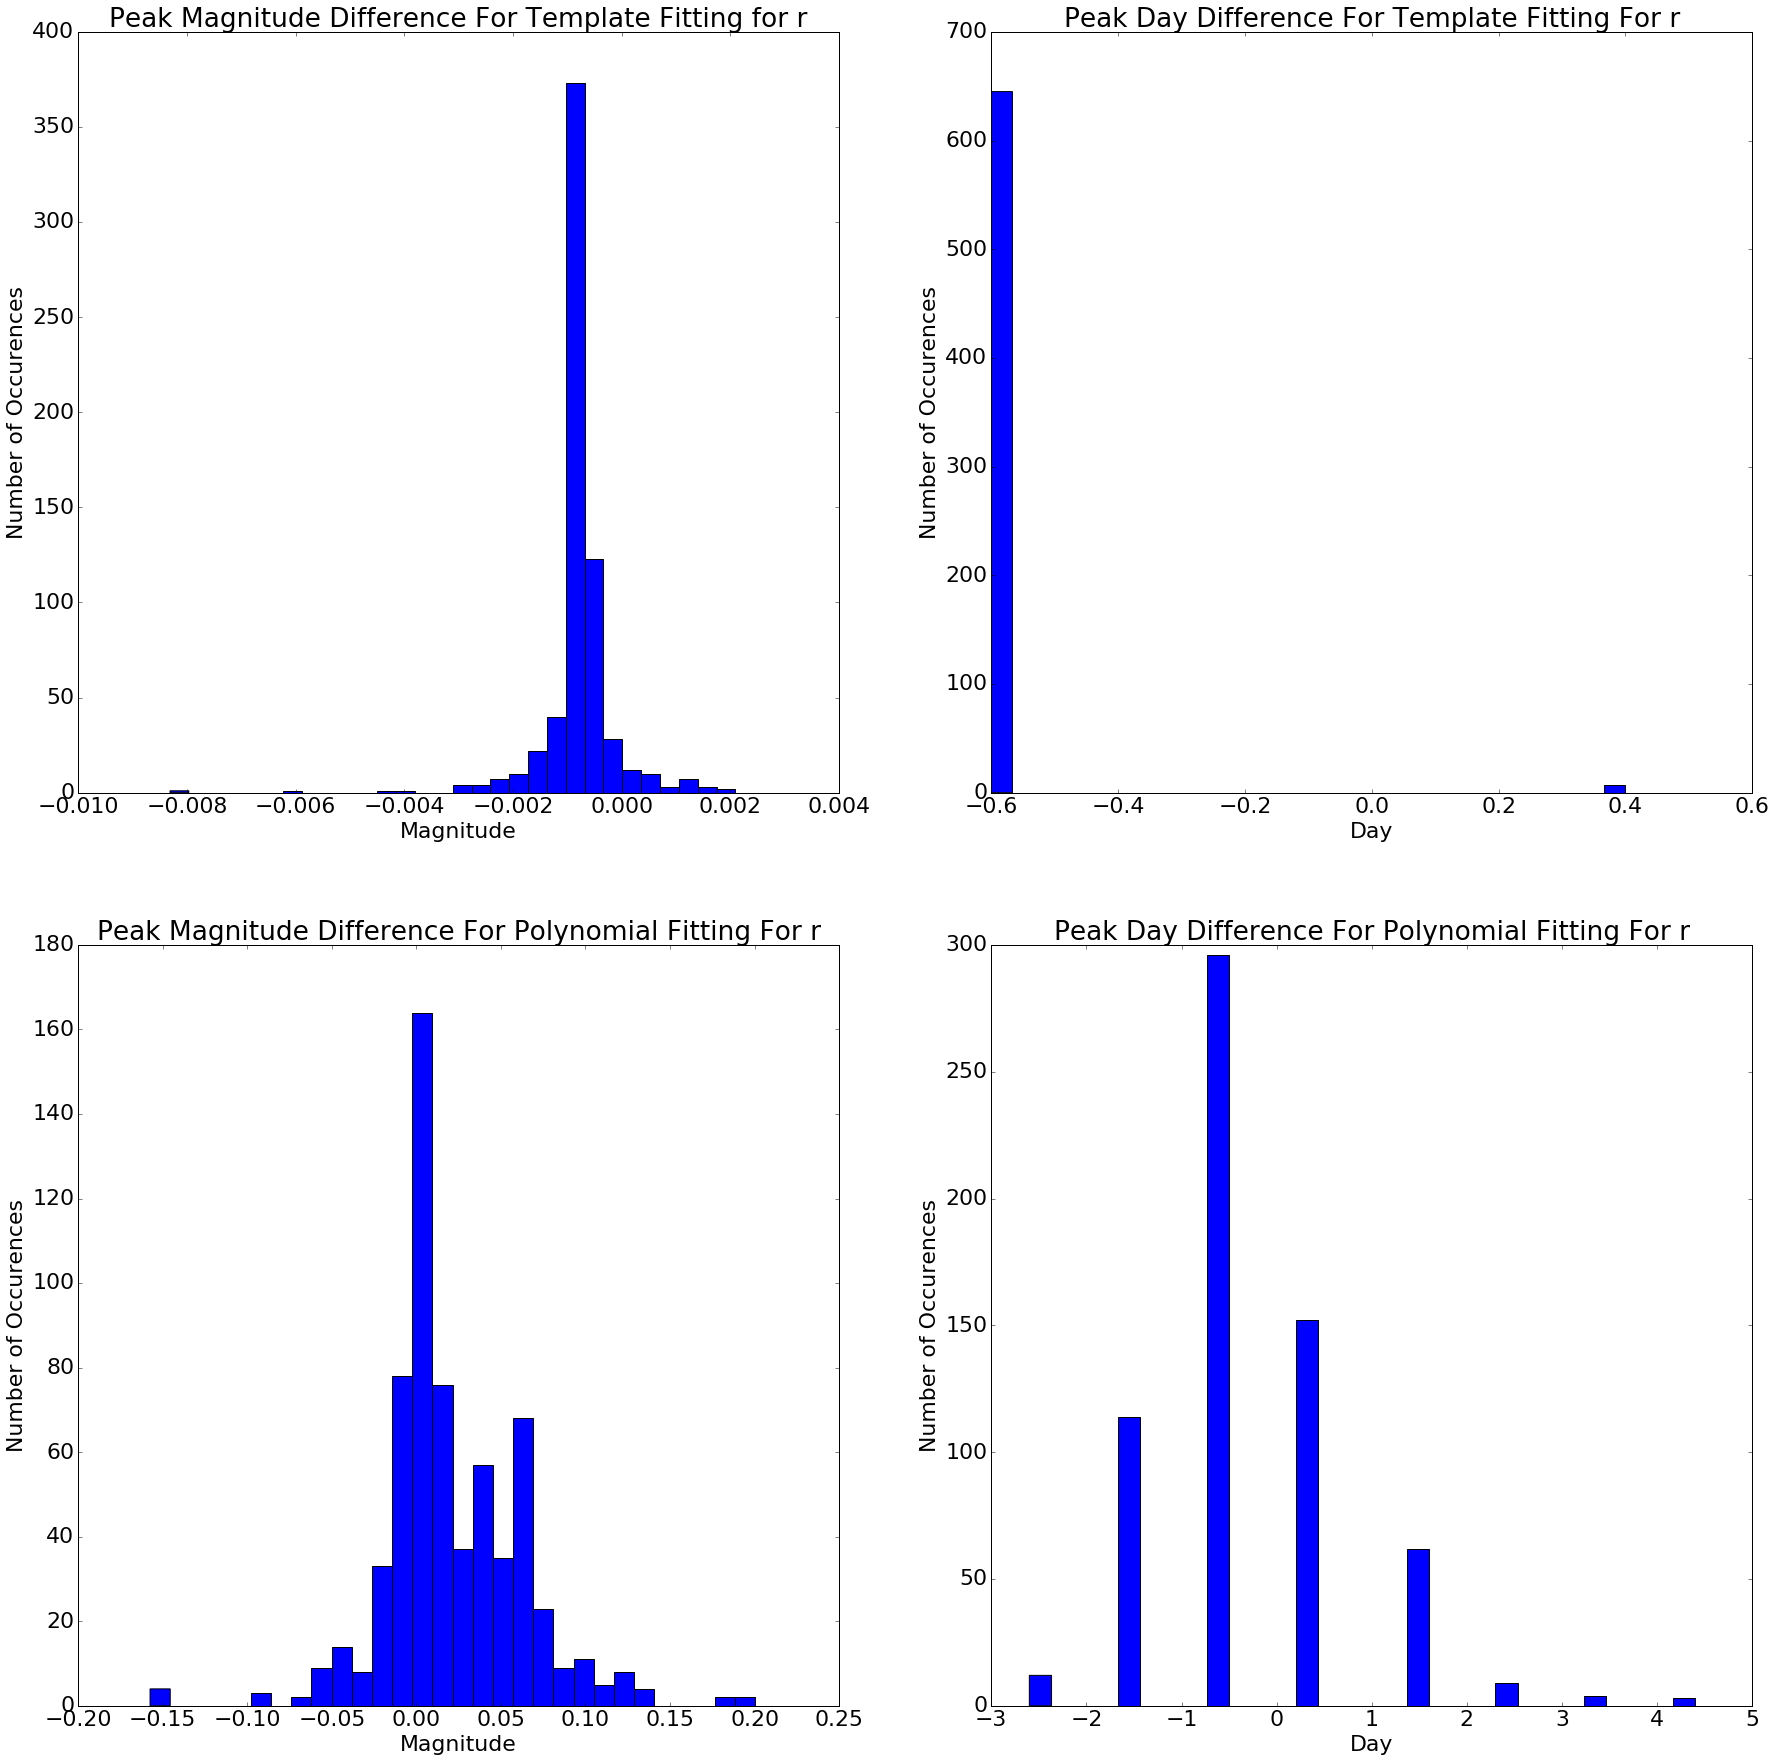

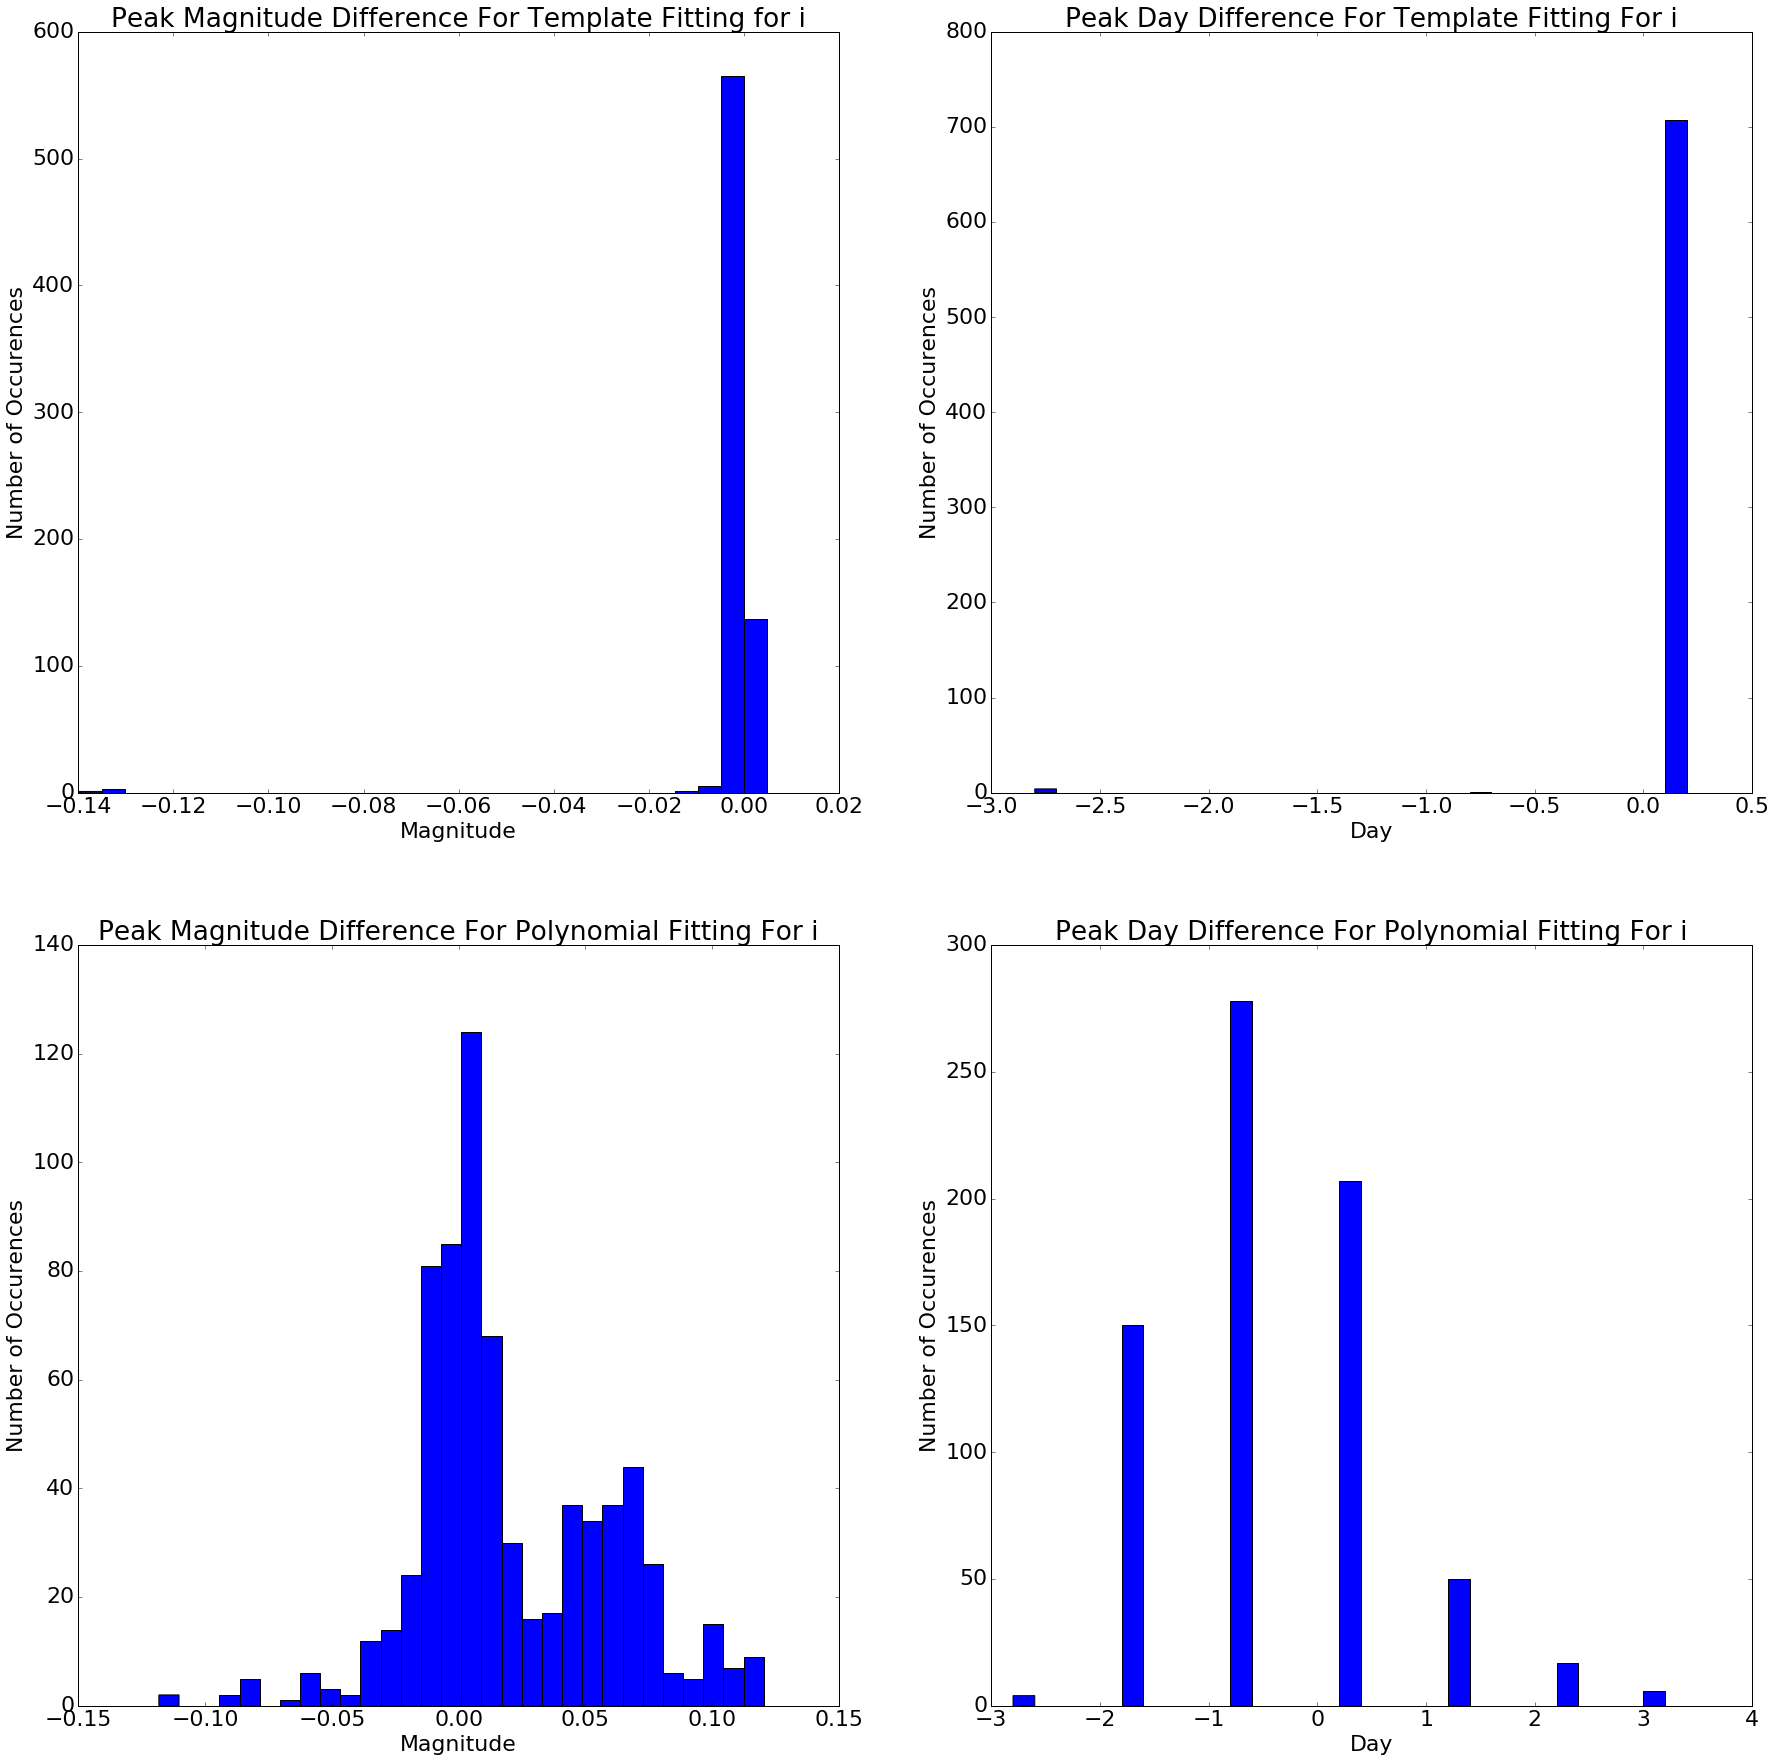

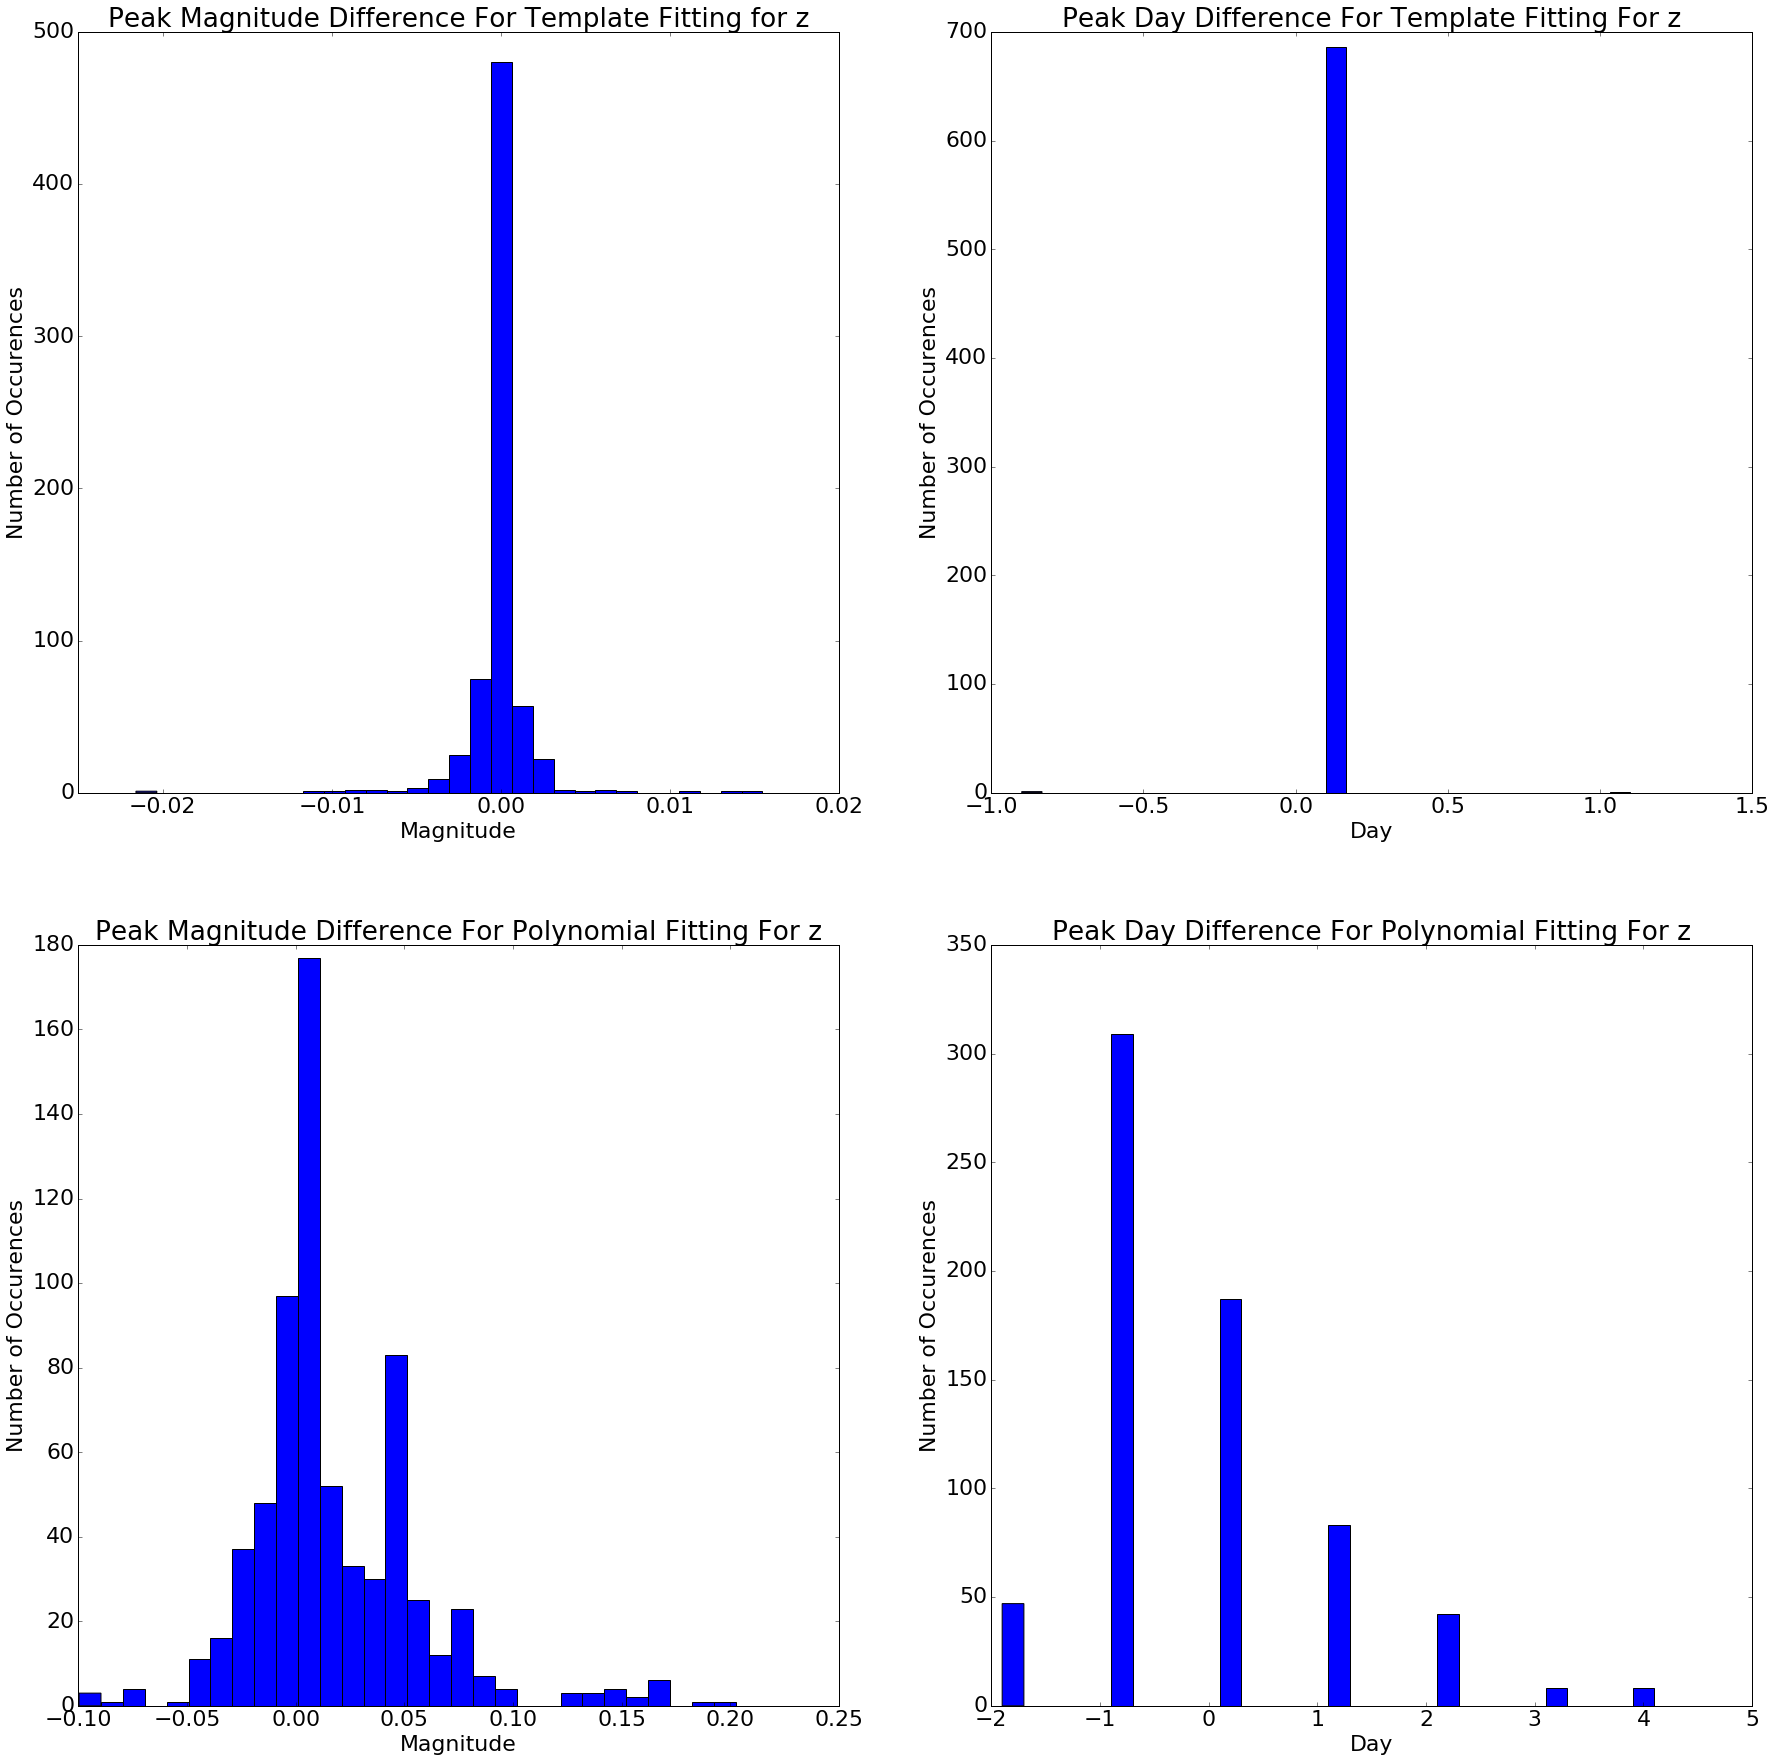

In [47]:
plt.rcParams.update({'font.size': 22})
for f in filterNames:
    
    f1, axarr = plt.subplots(2,2,figsize=(30,30))
    
    fMatch = peak_mag_difference_template['filter'] == f
    axarr[0,0].hist(peak_mag_difference_template[fMatch]['peak magnitude difference 1'], bins = 30)
    axarr[0,0].set_title('Peak Magnitude Difference For Template Fitting for ' + f)
    axarr[0,0].set_xlabel('Magnitude')
    axarr[0,0].set_ylabel('Number of Occurences')
    
    fMatch2 = peak_day_difference_template['filter'] == f
    axarr[0,1].hist(peak_day_difference_template[fMatch2]['peak day difference 1'], bins = 30)
    axarr[0,1].set_title('Peak Day Difference For Template Fitting For ' + f)
    axarr[0,1].set_xlabel('Day')
    axarr[0,1].set_ylabel('Number of Occurences')
    
    fMatch3 = peak_mag_difference_poly['filter'] == f
    axarr[1,0].hist(peak_mag_difference_poly[fMatch3]['peak magnitude difference 2'], bins = 30)
    axarr[1,0].set_title('Peak Magnitude Difference For Polynomial Fitting For ' + f)
    axarr[1,0].set_xlabel('Magnitude')
    axarr[1,0].set_ylabel('Number of Occurences')
    
    fMatch4 = peak_day_difference_poly['filter'] == f
    axarr[1,1].hist(peak_day_difference_poly[fMatch4]['peak day difference 2'], bins = 30)
    axarr[1,1].set_title('Peak Day Difference For Polynomial Fitting For ' + f)
    axarr[1,1].set_xlabel('Day')
    axarr[1,1].set_ylabel('Number of Occurences')
    
    f1.savefig("results_histograms_" + f + "_.pdf")
    